In [1]:
!pip install numpy ternary pandas scipy openpyxl

  Using cached ternary-0.1-py3-none-any.whl
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [openpyxl]2/3 [openpyxl]



LIQUAC MODEL - PARITY PLOT GENERATOR

CREATING PARITY PLOTS
Data loaded from: NaCl-DIPA/results_liquac.csv
Number of tie-lines: 25

✓ Figure saved: NaCl-DIPA/parity_plots_2x2.png


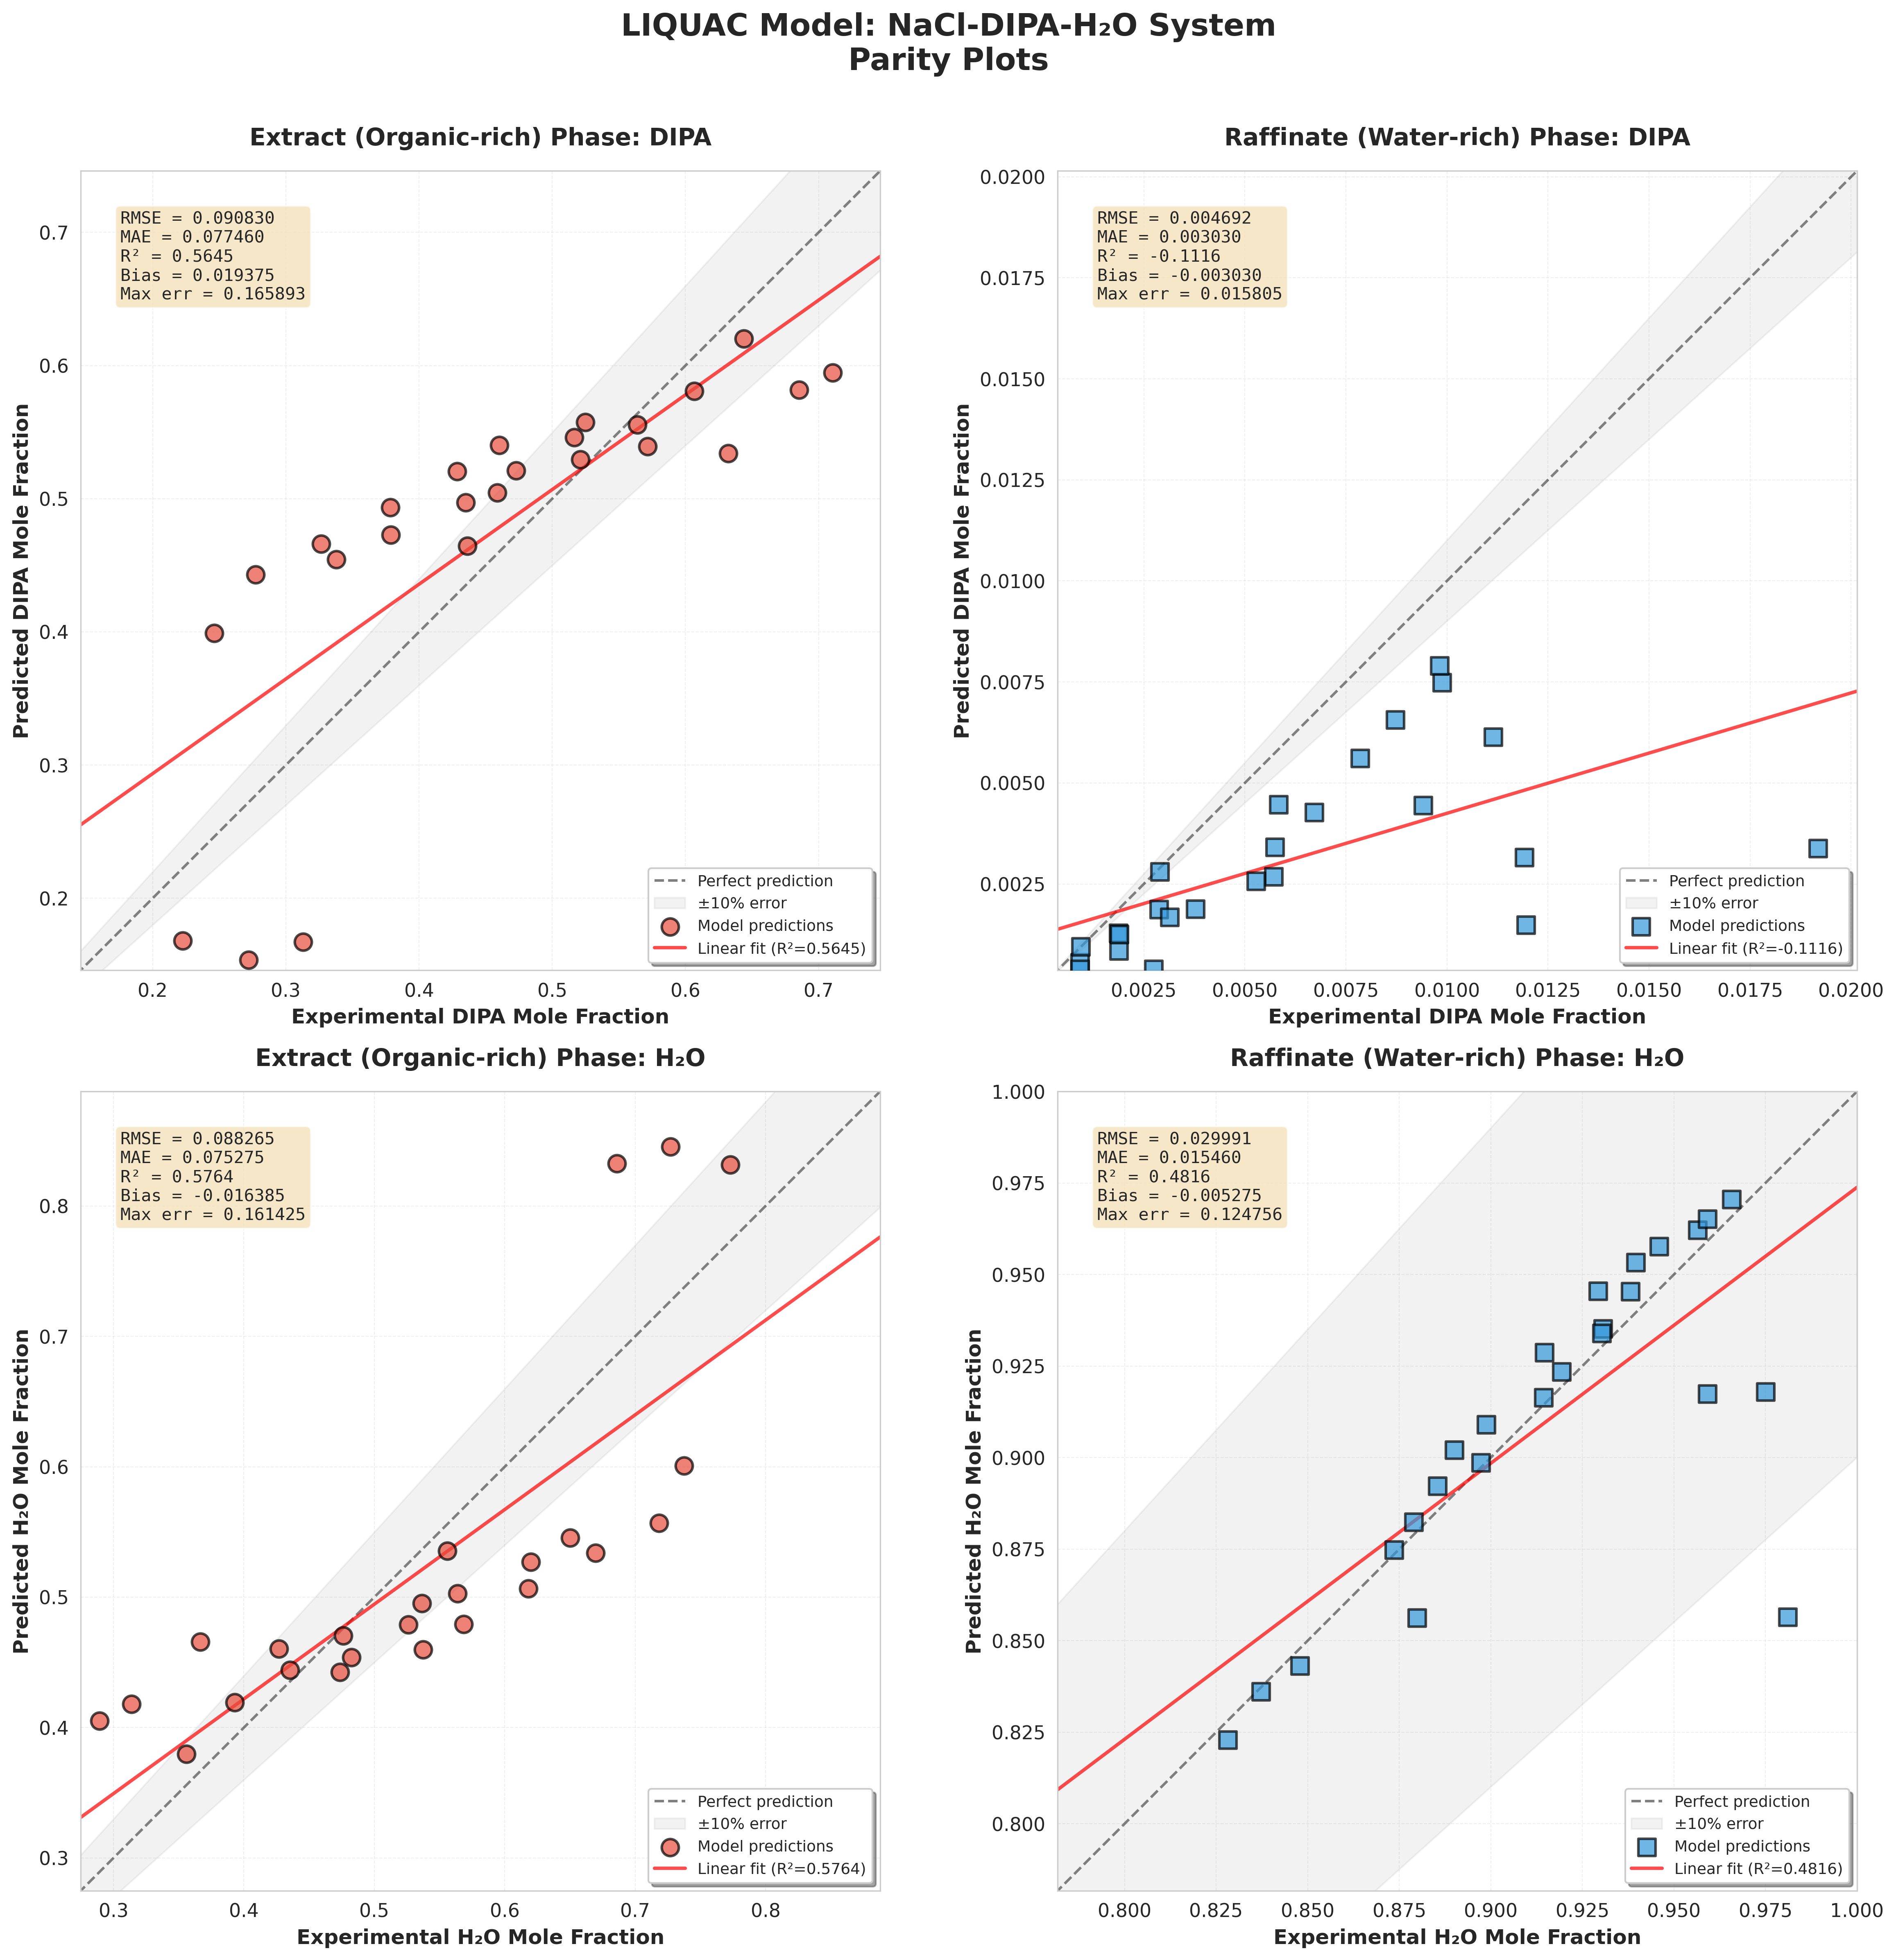


SUMMARY STATISTICS

DIPA in Extract Phase:
  RMSE: 0.090830
  R²:   0.5645

DIPA in Raffinate Phase:
  RMSE: 0.004692
  R²:   -0.1116

H₂O in Extract Phase:
  RMSE: 0.088265
  R²:   0.5764

H₂O in Raffinate Phase:
  RMSE: 0.029991
  R²:   0.4816



✓ Residual plots saved: NaCl-DIPA/residual_plots.png


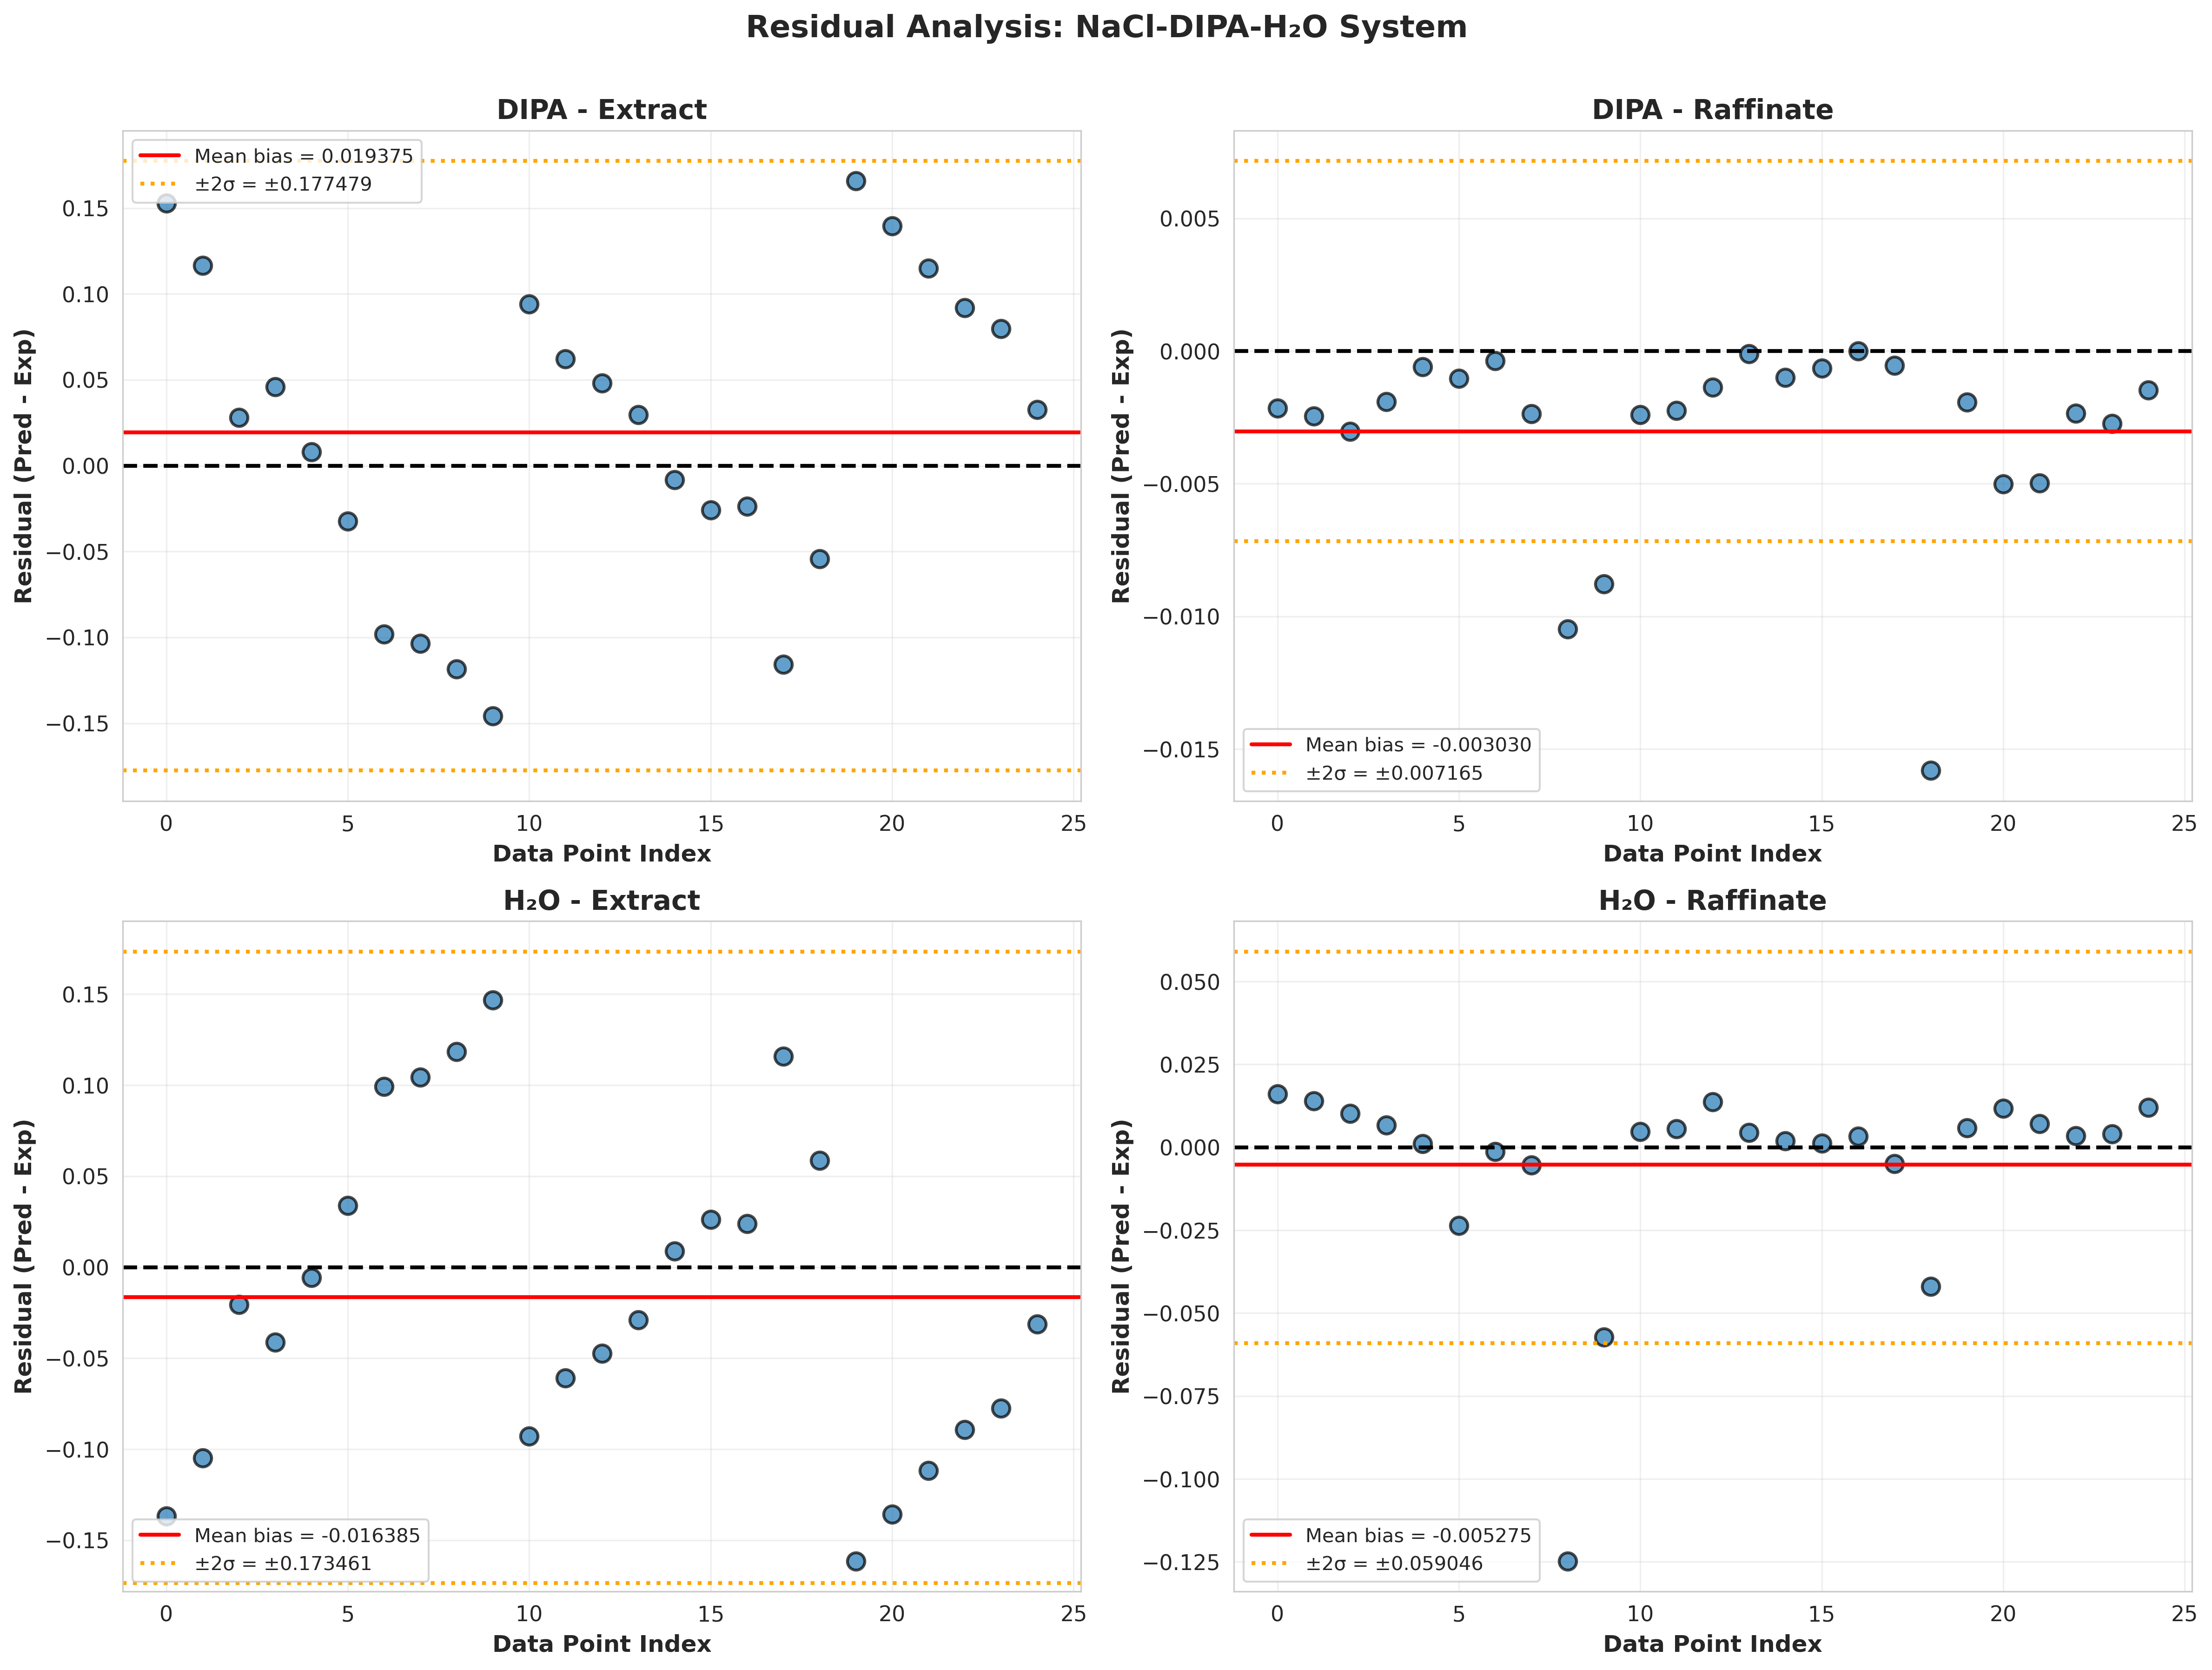


✓ Error histogram saved: NaCl-DIPA/error_histogram.png


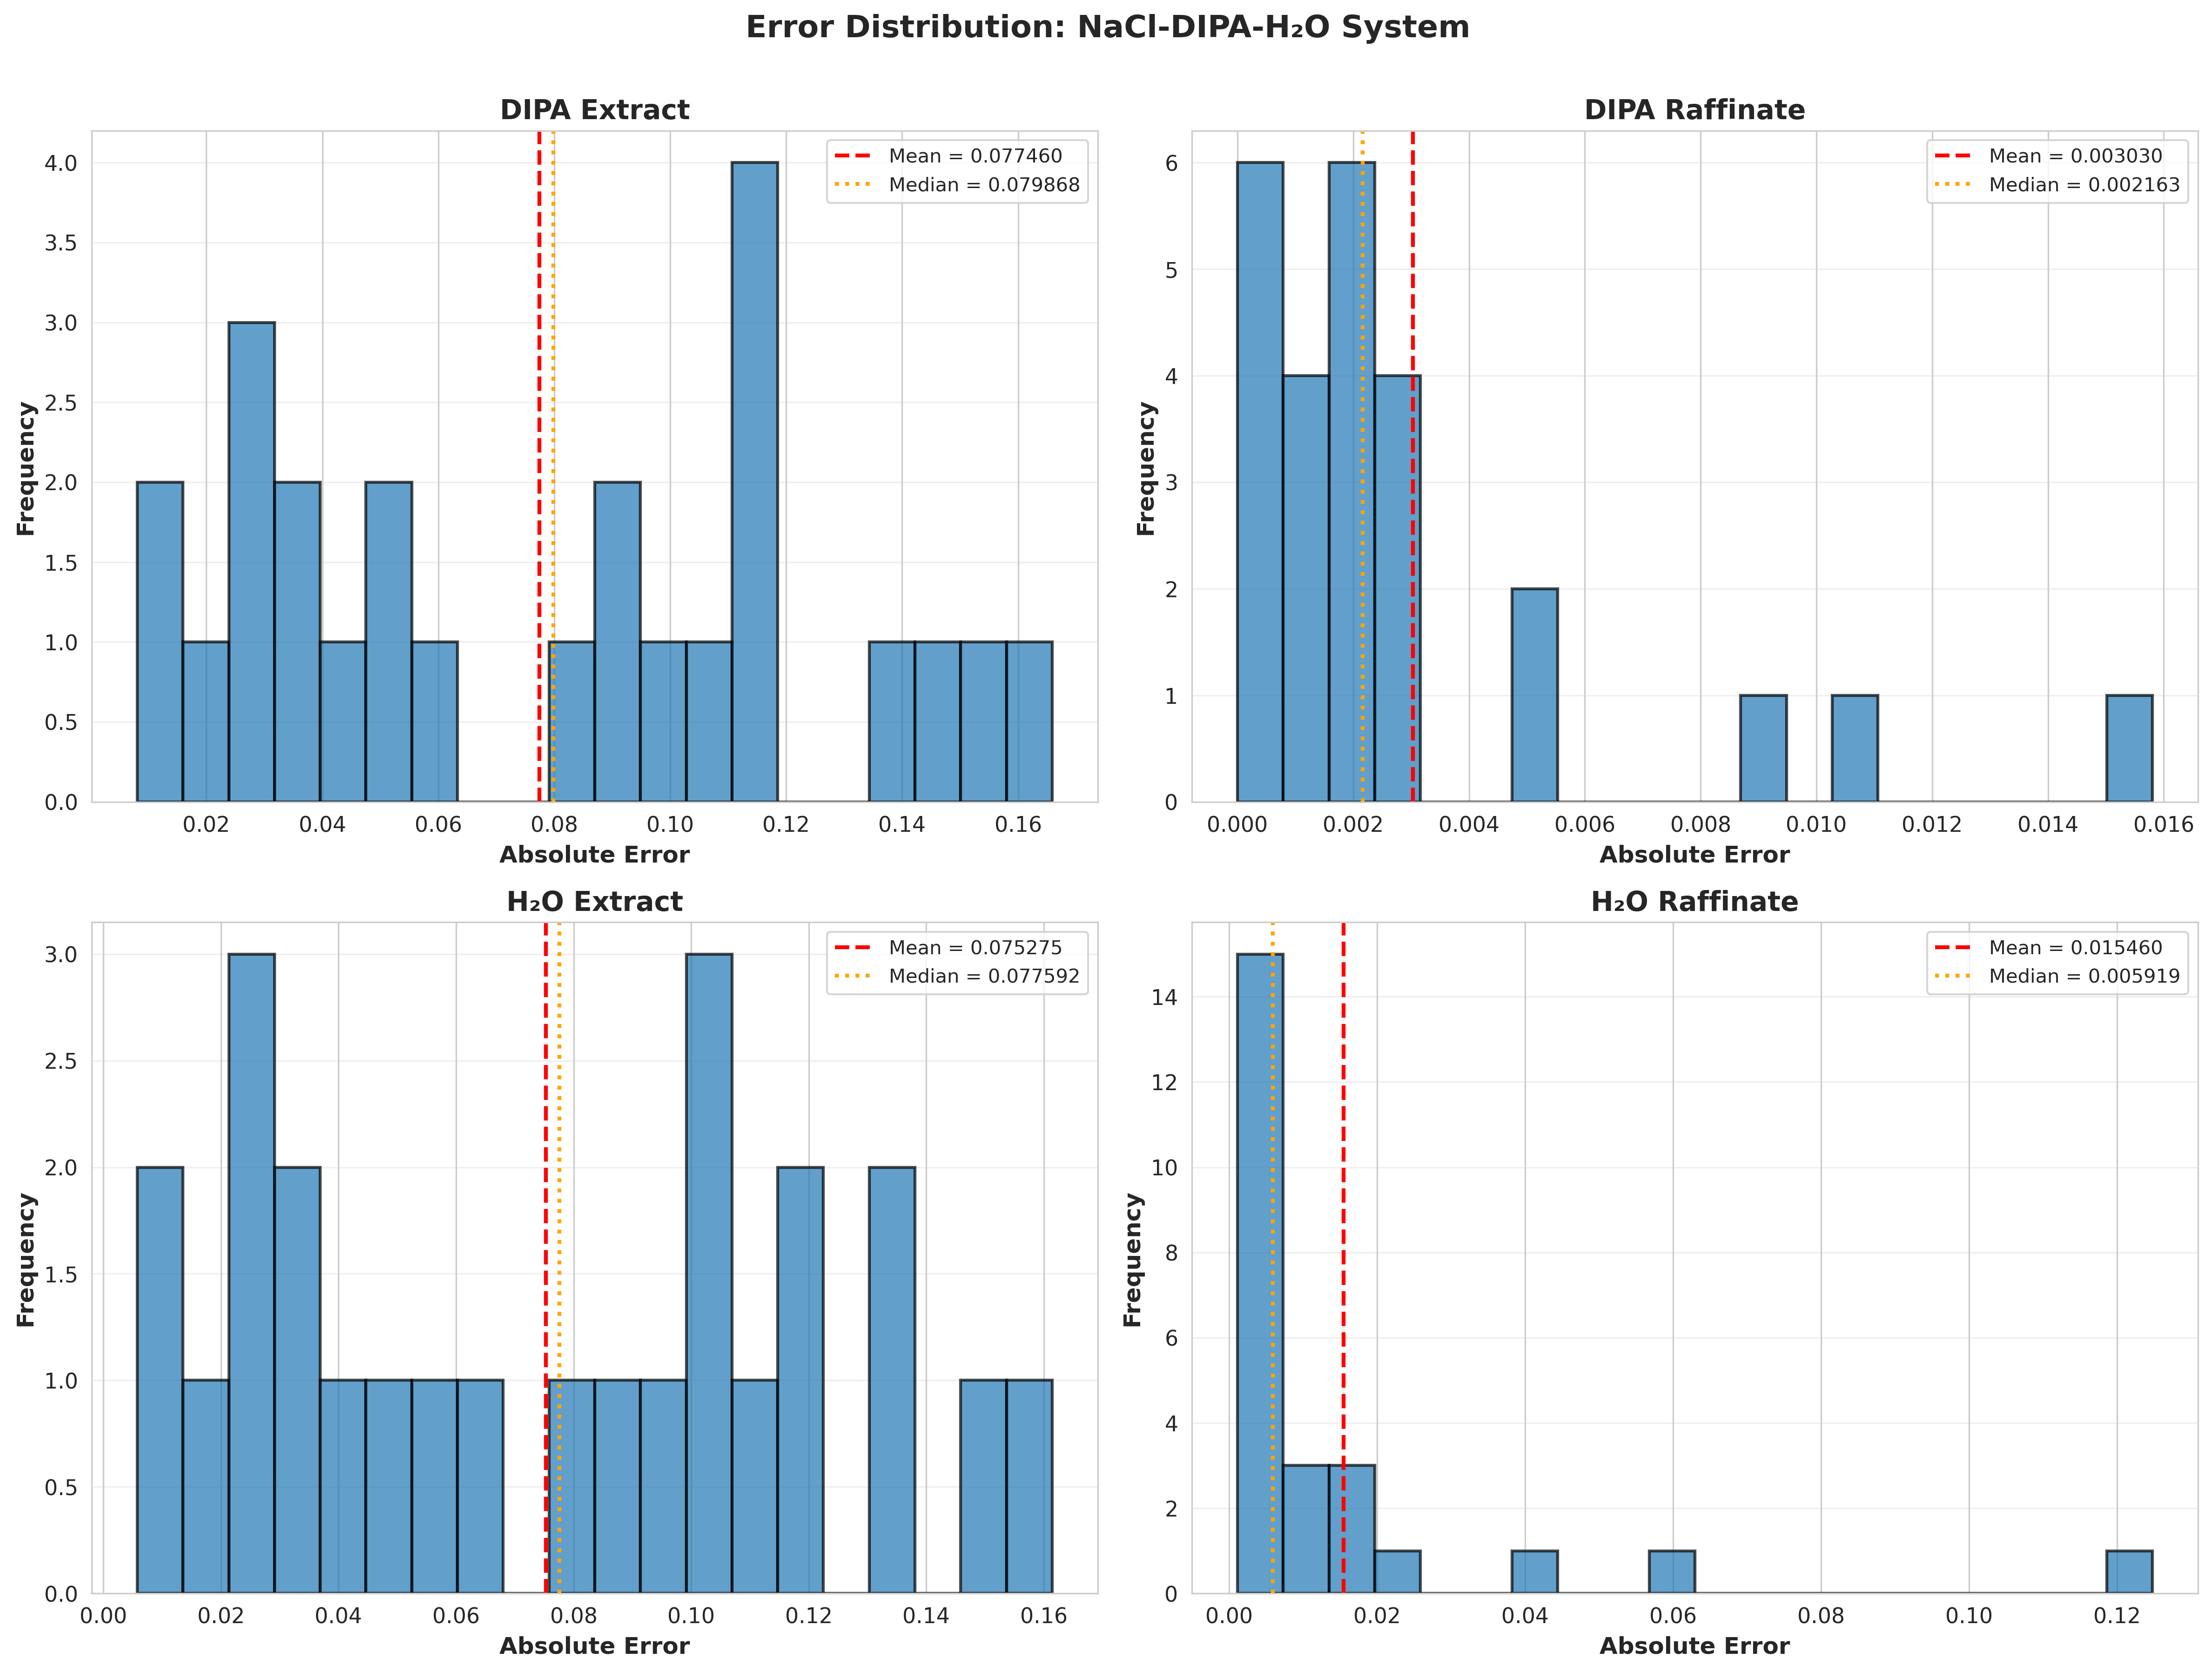


ALL PLOTS GENERATED SUCCESSFULLY!



In [2]:
# plot_parity.py
"""
Create parity plots for LIQUAC model predictions vs experimental data.

This script reads the results from liquac_fit.py and generates publication-quality
parity plots for DIPA and H2O in both extract and raffinate phases.

Usage:
    python plot_parity.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'

# ═══════════════════════════════════════════════════════════════════════════════
# USER SETTINGS
# ═══════════════════════════════════════════════════════════════════════════════

SALT = "NaCl"
SOLVENT = "DIPA"
DATA_DIR = ""  # Root directory containing NaCl-DIPA folder

SOLVENT_NAME = "DIPA"  # For plot labels
SAVE_FIGURES = True
OUTPUT_FORMAT = "png"  # "png", "pdf", or "svg"

# ═══════════════════════════════════════════════════════════════════════════════


def calculate_metrics(y_true, y_pred):
    """
    Calculate statistical metrics for model performance.
    
    Returns:
    --------
    dict with keys:
        - rmse: Root Mean Square Error
        - mae: Mean Absolute Error
        - r2: R-squared coefficient of determination
        - bias: Mean bias (pred - true)
        - max_error: Maximum absolute error
    """
    residuals = y_pred - y_true
    
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    
    # R² calculation
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)
    
    bias = np.mean(residuals)
    max_error = np.max(np.abs(residuals))
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'bias': bias,
        'max_error': max_error
    }


def create_parity_plot_single(ax, x_exp, x_pred, component_name, phase_name, 
                              color='blue', marker='o'):
    """
    Create a single parity plot on given axes.
    
    Parameters:
    -----------
    ax : matplotlib axes
    x_exp : array
        Experimental mole fractions
    x_pred : array
        Predicted mole fractions
    component_name : str
        Name of component (e.g., "DIPA", "H₂O")
    phase_name : str
        Phase name (e.g., "Extract", "Raffinate")
    color : str
        Color for scatter points
    marker : str
        Marker style
    """
    # Calculate metrics
    metrics = calculate_metrics(x_exp, x_pred)
    
    # Determine axis limits
    all_vals = np.concatenate([x_exp, x_pred])
    min_val = max(0, np.min(all_vals) * 0.95)
    max_val = min(1, np.max(all_vals) * 1.05)
    
    # Plot perfect prediction line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, 
            label='Perfect prediction', zorder=1)
    
    # Plot ±10% error bands
    x_line = np.linspace(0, 1, 100)
    ax.fill_between(x_line, x_line*0.9, x_line*1.1, 
                    color='gray', alpha=0.1, label='±10% error')
    
    # Scatter plot
    ax.scatter(x_exp, x_pred, c=color, marker=marker, s=100, 
              alpha=0.7, edgecolors='black', linewidth=1.5, zorder=3,
              label='Model predictions')
    
    # Linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_exp, x_pred)
    x_fit = np.linspace(min_val, max_val, 100)
    y_fit = slope * x_fit + intercept
    ax.plot(x_fit, y_fit, 'r-', linewidth=2, alpha=0.7,
           label=f'Linear fit (R²={metrics["r2"]:.4f})')
    
    # Set labels and title
    ax.set_xlabel(f'Experimental {component_name} Mole Fraction', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Predicted {component_name} Mole Fraction', 
                 fontsize=12, fontweight='bold')
    ax.set_title(f'{phase_name} Phase: {component_name}', 
                fontsize=14, fontweight='bold', pad=15)
    
    # Set axis limits
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_aspect('equal', adjustable='box')
    
    # Add metrics text box
    metrics_text = (
        f'RMSE = {metrics["rmse"]:.6f}\n'
        f'MAE = {metrics["mae"]:.6f}\n'
        f'R² = {metrics["r2"]:.4f}\n'
        f'Bias = {metrics["bias"]:.6f}\n'
        f'Max err = {metrics["max_error"]:.6f}'
    )
    
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
           fontfamily='monospace')
    
    # Grid and legend
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.legend(loc='lower right', fontsize=9, frameon=True, 
             fancybox=True, shadow=True)
    
    return metrics


def create_combined_parity_plots():
    """
    Create a 2x2 grid of parity plots:
    - Top row: DIPA (Extract and Raffinate)
    - Bottom row: H2O (Extract and Raffinate)
    """
    # Load data
    data_dir = Path(DATA_DIR) / f"{SALT}-{SOLVENT}"
    results = pd.read_csv(data_dir / "results_liquac.csv")
    
    print("\n" + "="*70)
    print("CREATING PARITY PLOTS")
    print("="*70)
    print(f"Data loaded from: {data_dir / 'results_liquac.csv'}")
    print(f"Number of tie-lines: {len(results)}")
    
    # Extract data
    xE_solv_exp = results['xE_exp_solvent'].values
    xE_solv_pred = results['xE_solvent'].values
    xE_water_exp = results['xE_exp_water'].values
    xE_water_pred = results['xE_water'].values
    
    xR_solv_exp = results['xR_exp_solvent'].values
    xR_solv_pred = results['xR_solvent'].values
    xR_water_exp = results['xR_exp_water'].values
    xR_water_pred = results['xR_water'].values
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # Plot 1: DIPA in Extract (top-left)
    metrics_E_DIPA = create_parity_plot_single(
        axes[0, 0], xE_solv_exp, xE_solv_pred, 
        SOLVENT_NAME, 'Extract (Organic-rich)',
        color='#e74c3c', marker='o'
    )
    
    # Plot 2: DIPA in Raffinate (top-right)
    metrics_R_DIPA = create_parity_plot_single(
        axes[0, 1], xR_solv_exp, xR_solv_pred,
        SOLVENT_NAME, 'Raffinate (Water-rich)',
        color='#3498db', marker='s'
    )
    
    # Plot 3: H2O in Extract (bottom-left)
    metrics_E_H2O = create_parity_plot_single(
        axes[1, 0], xE_water_exp, xE_water_pred,
        'H₂O', 'Extract (Organic-rich)',
        color='#e74c3c', marker='o'
    )
    
    # Plot 4: H2O in Raffinate (bottom-right)
    metrics_R_H2O = create_parity_plot_single(
        axes[1, 1], xR_water_exp, xR_water_pred,
        'H₂O', 'Raffinate (Water-rich)',
        color='#3498db', marker='s'
    )
    
    # Overall title
    plt.suptitle(f'LIQUAC Model: {SALT}-{SOLVENT_NAME}-H₂O System\nParity Plots', 
                fontsize=18, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    # Save figure
    if SAVE_FIGURES:
        output_path = data_dir / f'parity_plots_2x2.{OUTPUT_FORMAT}'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Figure saved: {output_path}")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    
    print(f"\n{SOLVENT_NAME} in Extract Phase:")
    print(f"  RMSE: {metrics_E_DIPA['rmse']:.6f}")
    print(f"  R²:   {metrics_E_DIPA['r2']:.4f}")
    
    print(f"\n{SOLVENT_NAME} in Raffinate Phase:")
    print(f"  RMSE: {metrics_R_DIPA['rmse']:.6f}")
    print(f"  R²:   {metrics_R_DIPA['r2']:.4f}")
    
    print(f"\nH₂O in Extract Phase:")
    print(f"  RMSE: {metrics_E_H2O['rmse']:.6f}")
    print(f"  R²:   {metrics_E_H2O['r2']:.4f}")
    
    print(f"\nH₂O in Raffinate Phase:")
    print(f"  RMSE: {metrics_R_H2O['rmse']:.6f}")
    print(f"  R²:   {metrics_R_H2O['r2']:.4f}")
    
    print("\n" + "="*70 + "\n")
    
    return {
        'DIPA_Extract': metrics_E_DIPA,
        'DIPA_Raffinate': metrics_R_DIPA,
        'H2O_Extract': metrics_E_H2O,
        'H2O_Raffinate': metrics_R_H2O
    }


def create_separate_plots():
    """
    Create individual parity plots for each component/phase combination.
    Useful for presentations or publications where you want larger individual plots.
    """
    # Load data
    data_dir = Path(DATA_DIR) / f"{SALT}-{SOLVENT}"
    results = pd.read_csv(data_dir / "results_liquac.csv")
    
    # Extract data
    data_dict = {
        'DIPA_Extract': (results['xE_exp_solvent'].values, results['xE_solvent'].values),
        'DIPA_Raffinate': (results['xR_exp_solvent'].values, results['xR_solvent'].values),
        'H2O_Extract': (results['xE_exp_water'].values, results['xE_water'].values),
        'H2O_Raffinate': (results['xR_exp_water'].values, results['xR_water'].values),
    }
    
    colors = {
        'DIPA_Extract': '#e74c3c',
        'DIPA_Raffinate': '#3498db',
        'H2O_Extract': '#e74c3c',
        'H2O_Raffinate': '#3498db',
    }
    
    markers = {
        'DIPA_Extract': 'o',
        'DIPA_Raffinate': 's',
        'H2O_Extract': 'o',
        'H2O_Raffinate': 's',
    }
    
    print("\n" + "="*70)
    print("CREATING INDIVIDUAL PARITY PLOTS")
    print("="*70)
    
    for key, (x_exp, x_pred) in data_dict.items():
        component, phase = key.split('_')
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        create_parity_plot_single(
            ax, x_exp, x_pred,
            component if component == 'DIPA' else 'H₂O',
            f'{phase} ({"Organic-rich" if phase == "Extract" else "Water-rich"})',
            color=colors[key],
            marker=markers[key]
        )
        
        plt.tight_layout()
        
        if SAVE_FIGURES:
            output_path = data_dir / f'parity_{key.lower()}.{OUTPUT_FORMAT}'
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"✓ {output_path}")
        
        plt.show()
    
    print("\n" + "="*70 + "\n")


def create_residual_plots():
    """
    Create residual plots to assess model bias and error distribution.
    """
    # Load data
    data_dir = Path(DATA_DIR) / f"{SALT}-{SOLVENT}"
    results = pd.read_csv(data_dir / "results_liquac.csv")
    
    # Calculate residuals
    residuals = {
        'DIPA_Extract': results['xE_solvent'] - results['xE_exp_solvent'],
        'DIPA_Raffinate': results['xR_solvent'] - results['xR_exp_solvent'],
        'H2O_Extract': results['xE_water'] - results['xE_exp_water'],
        'H2O_Raffinate': results['xR_water'] - results['xR_exp_water'],
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    titles = [
        'DIPA - Extract', 'DIPA - Raffinate',
        'H₂O - Extract', 'H₂O - Raffinate'
    ]
    
    for idx, (key, resid) in enumerate(residuals.items()):
        ax = axes[idx // 2, idx % 2]
        
        # Scatter plot
        ax.scatter(range(len(resid)), resid, s=80, alpha=0.7, 
                  edgecolors='black', linewidth=1.5)
        ax.axhline(y=0, color='k', linestyle='--', linewidth=2)
        
        # Mean residual line
        mean_resid = np.mean(resid)
        ax.axhline(y=mean_resid, color='r', linestyle='-', linewidth=2,
                  label=f'Mean bias = {mean_resid:.6f}')
        
        # ±2σ bounds
        std_resid = np.std(resid)
        ax.axhline(y=2*std_resid, color='orange', linestyle=':', linewidth=2,
                  label=f'±2σ = ±{2*std_resid:.6f}')
        ax.axhline(y=-2*std_resid, color='orange', linestyle=':', linewidth=2)
        
        ax.set_xlabel('Data Point Index', fontsize=12, fontweight='bold')
        ax.set_ylabel('Residual (Pred - Exp)', fontsize=12, fontweight='bold')
        ax.set_title(titles[idx], fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Residual Analysis: {SALT}-{SOLVENT_NAME}-H₂O System',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    if SAVE_FIGURES:
        output_path = data_dir / f'residual_plots.{OUTPUT_FORMAT}'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Residual plots saved: {output_path}")
    
    plt.show()


def create_error_histogram():
    """
    Create histograms of prediction errors.
    """
    # Load data
    data_dir = Path(DATA_DIR) / f"{SALT}-{SOLVENT}"
    results = pd.read_csv(data_dir / "results_liquac.csv")
    
    # Calculate absolute errors
    errors = {
        'DIPA Extract': np.abs(results['xE_solvent'] - results['xE_exp_solvent']),
        'DIPA Raffinate': np.abs(results['xR_solvent'] - results['xR_exp_solvent']),
        'H₂O Extract': np.abs(results['xE_water'] - results['xE_exp_water']),
        'H₂O Raffinate': np.abs(results['xR_water'] - results['xR_exp_water']),
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for idx, (key, err) in enumerate(errors.items()):
        ax = axes[idx // 2, idx % 2]
        
        ax.hist(err, bins=20, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.axvline(x=np.mean(err), color='r', linestyle='--', linewidth=2,
                  label=f'Mean = {np.mean(err):.6f}')
        ax.axvline(x=np.median(err), color='orange', linestyle=':', linewidth=2,
                  label=f'Median = {np.median(err):.6f}')
        
        ax.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_title(key, fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Error Distribution: {SALT}-{SOLVENT_NAME}-H₂O System',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    if SAVE_FIGURES:
        output_path = data_dir / f'error_histogram.{OUTPUT_FORMAT}'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Error histogram saved: {output_path}")
    
    plt.show()


if __name__ == "__main__":
    print("\n" + "="*70)
    print("LIQUAC MODEL - PARITY PLOT GENERATOR")
    print("="*70)
    
    # Create main 2x2 parity plots
    metrics = create_combined_parity_plots()
    
    # Optionally create individual plots (uncomment if needed)
    # create_separate_plots()
    
    # Create residual analysis
    create_residual_plots()
    
    # Create error histograms
    create_error_histogram()
    
    print("\n" + "="*70)
    print("ALL PLOTS GENERATED SUCCESSFULLY!")
    print("="*70 + "\n")



LIQUAC MODEL - PAPER-STYLE PARITY PLOTS



/tmp/ipykernel_3927/3368430768.py:117: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  scatter2 = ax1.scatter(data['xR_DIPA_exp'], data['xR_DIPA_pred'],
/tmp/ipykernel_3927/3368430768.py:125: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax1_inset.scatter(data['xR_DIPA_exp'], data['xR_DIPA_pred'],
/tmp/ipykernel_3927/3368430768.py:174: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  scatter4 = ax2.scatter(data['xR_H2O_exp'], data['xR_H2O_pred'],



✓ Paper-style parity plots saved: NaCl-DIPA/parity_plots_paper_style.png


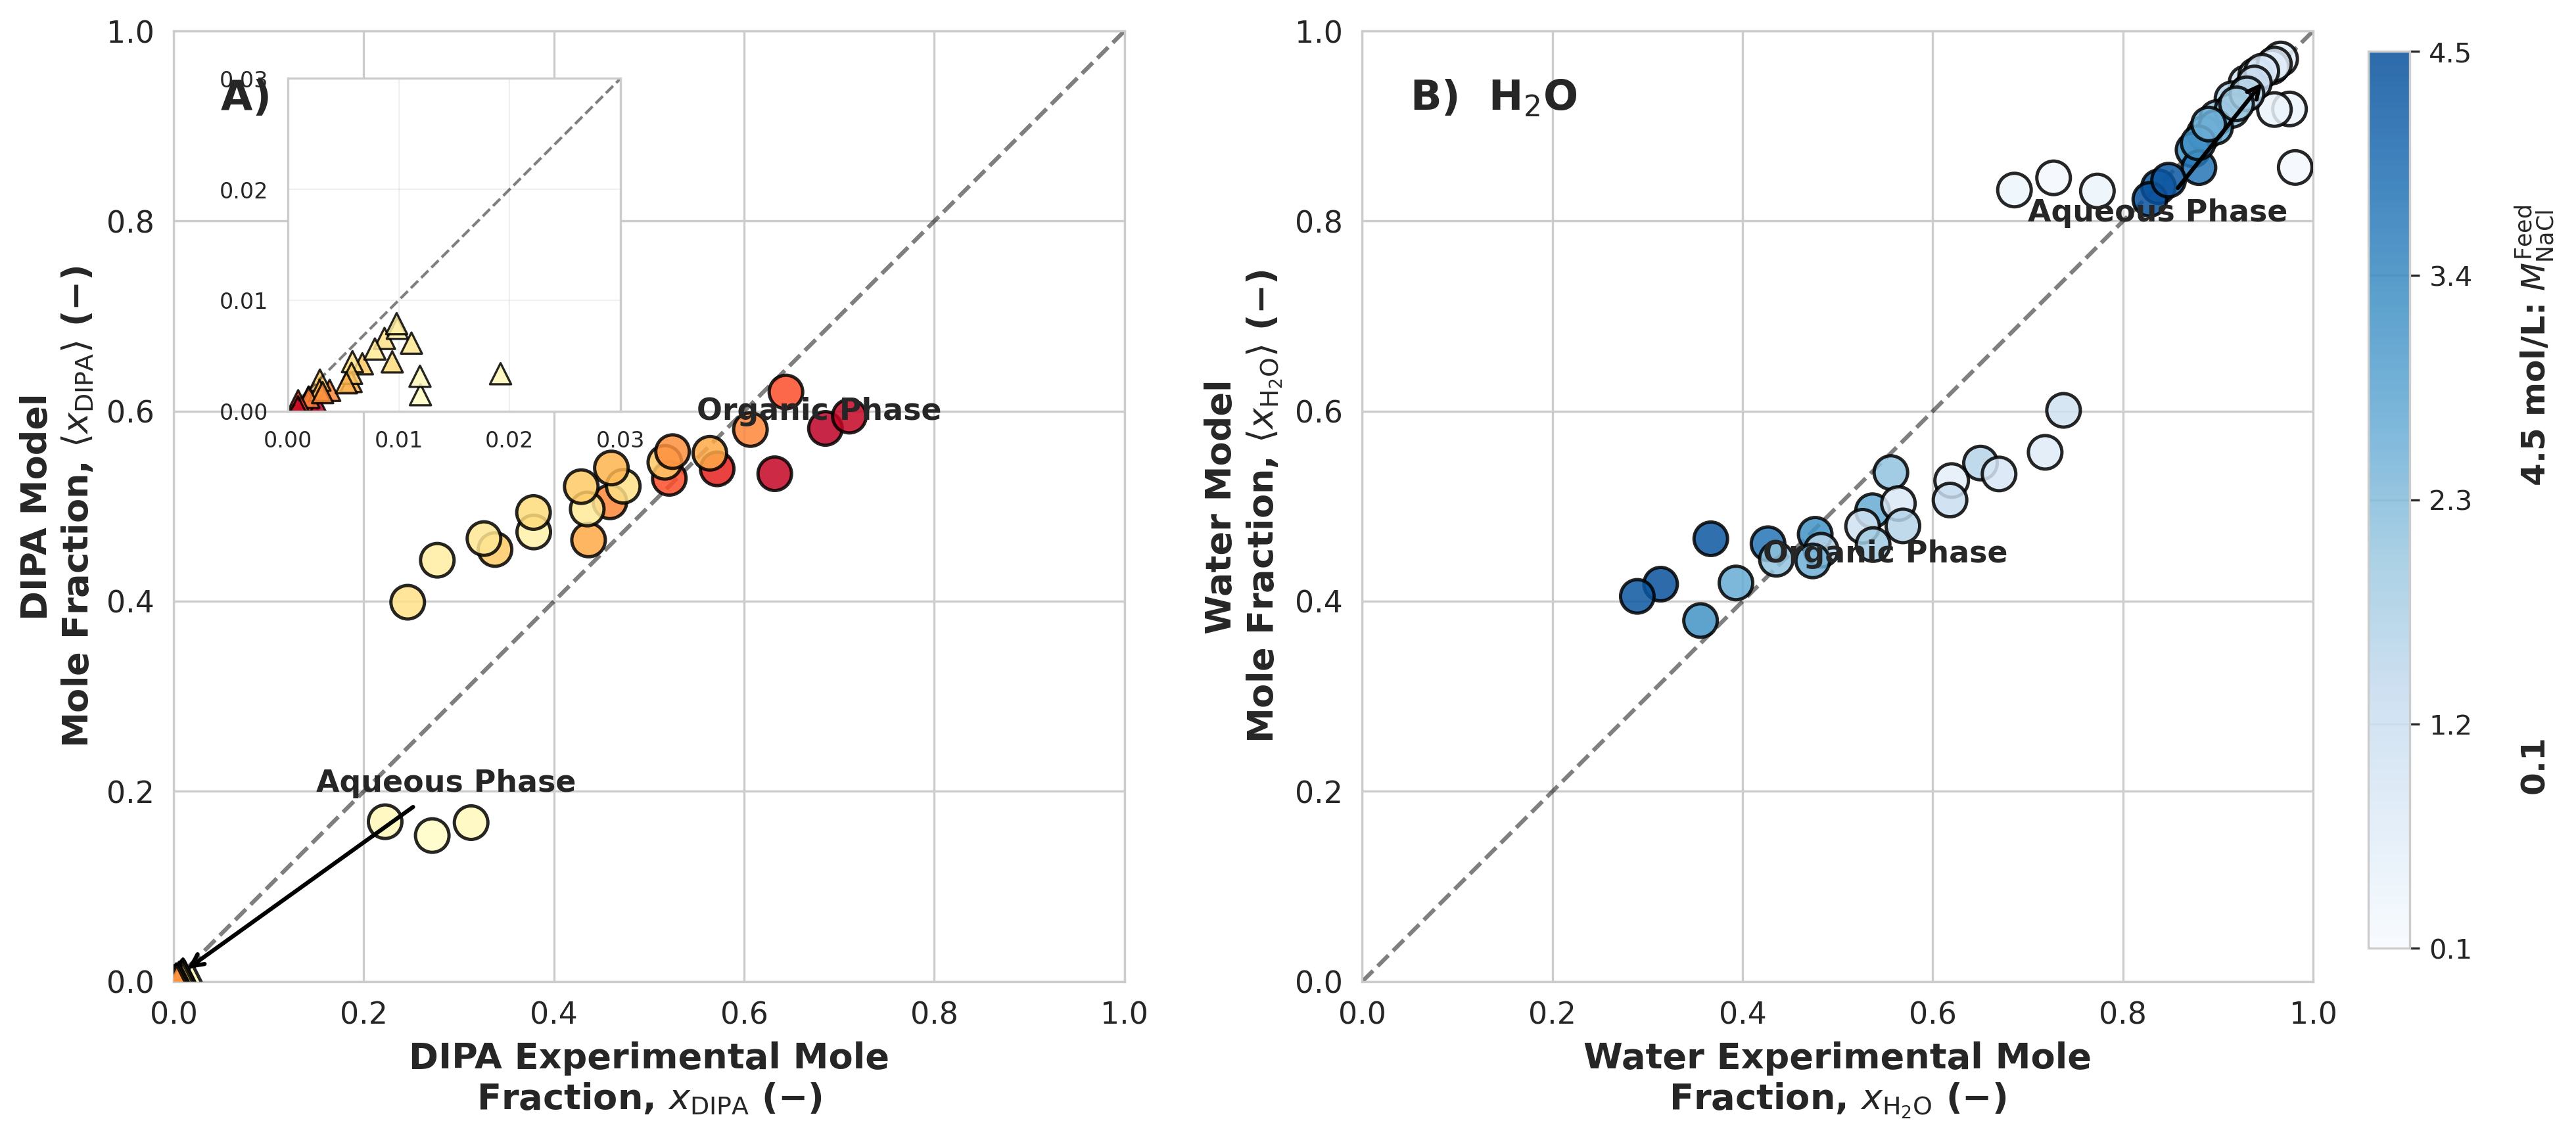


PREDICTION STATISTICS
Component     Phase     RMSE      MAE        R²      Bias  Max Error  Mean Exp  Mean Pred
     DIPA   Extract 0.090830 0.077460  0.564525  0.019375   0.165893  0.456841   0.476216
     DIPA Raffinate 0.004692 0.003030 -0.111645 -0.003030   0.015805  0.006125   0.003095
      H2O   Extract 0.088265 0.075275  0.576415 -0.016385   0.161425  0.540031   0.523646
      H2O Raffinate 0.029991 0.015460  0.481564 -0.005275   0.124756  0.915109   0.909835

✓ Statistics saved to: NaCl-DIPA/parity_statistics.csv

ALL PLOTS GENERATED SUCCESSFULLY!



In [3]:
# plot_parity_paper_style.py
"""
Create publication-quality parity plots matching the paper style.

Generates parity plots for DIPA and H2O with:
- Color mapping by salt concentration
- Inset zoom for aqueous phase
- Clean, professional appearance
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches
from pathlib import Path

# ═══════════════════════════════════════════════════════════════════════════════
# USER SETTINGS
# ═══════════════════════════════════════════════════════════════════════════════

SALT = "NaCl"
SOLVENT = "DIPA"
DATA_DIR = ""  # Root directory containing NaCl-DIPA folder

SAVE_FIGURES = True
OUTPUT_FORMAT = "png"  # "png", "pdf", or "svg"
DPI = 600  # High resolution for publication

# ═══════════════════════════════════════════════════════════════════════════════


def load_data():
    """Load experimental and predicted data."""
    data_dir = Path(DATA_DIR) / f"{SALT}-{SOLVENT}"
    results = pd.read_csv(data_dir / "results_liquac.csv")
    
    # Load experimental data to get salt concentrations
    z_exp = pd.read_excel(data_dir / "z_exp.xlsx").values
    
    # Calculate salt molality in feed (mol/L approximation)
    # Using density of water ≈ 1000 kg/m³
    MW_NaCl = 0.058443  # kg/mol
    MW_water = 0.018015  # kg/mol
    
    # Approximate molality from mole fraction
    # For dilute solutions: molality ≈ x_salt / (x_water * MW_water)
    x_salt_feed = z_exp[:, 2]  # Na+ mole fraction (same as Cl-)
    x_water_feed = z_exp[:, 1]
    
    # Convert to molality (mol/kg solvent)
    m_salt = x_salt_feed / (x_water_feed * MW_water)
    
    data = {
        'xE_DIPA_exp': results['xE_exp_solvent'].values,
        'xE_DIPA_pred': results['xE_solvent'].values,
        'xE_H2O_exp': results['xE_exp_water'].values,
        'xE_H2O_pred': results['xE_water'].values,
        'xR_DIPA_exp': results['xR_exp_solvent'].values,
        'xR_DIPA_pred': results['xR_solvent'].values,
        'xR_H2O_exp': results['xR_exp_water'].values,
        'xR_H2O_pred': results['xR_water'].values,
        'molality': m_salt
    }
    
    return data


def create_colormap():
    """
    Create custom colormap matching paper style.
    Orange-red for DIPA, Blue for H2O.
    """
    # Orange-red colormap for DIPA (light yellow to dark red)
    colors_dipa = ['#FFFFCC', '#FFEDA0', '#FED976', '#FEB24C', 
                   '#FD8D3C', '#FC4E2A', '#E31A1C', '#BD0026']
    cmap_dipa = LinearSegmentedColormap.from_list('dipa', colors_dipa)
    
    # Blue colormap for H2O (light to dark blue)
    colors_h2o = ['#F7FBFF', '#DEEBF7', '#C6DBEF', '#9ECAE1',
                  '#6BAED6', '#4292C6', '#2171B5', '#08519C']
    cmap_h2o = LinearSegmentedColormap.from_list('h2o', colors_h2o)
    
    return cmap_dipa, cmap_h2o


def create_paper_style_parity_plot():
    """
    Create parity plots matching the paper style with side-by-side panels.
    """
    data = load_data()
    cmap_dipa, cmap_h2o = create_colormap()
    
    # Normalize molality for color mapping (0 to 4.5 mol/L range)
    m_norm = data['molality'] / 4.5
    m_norm = np.clip(m_norm, 0, 1)  # Ensure within [0, 1]
    
    # Create figure with two panels side by side
    fig = plt.figure(figsize=(14, 6.5))
    gs = fig.add_gridspec(1, 2, wspace=0.25)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Panel A: DIPA
    # ─────────────────────────────────────────────────────────────────────────
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Plot diagonal line
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, zorder=1)
    
    # Plot organic phase data (filled circles, color by salt concentration)
    scatter1 = ax1.scatter(data['xE_DIPA_exp'], data['xE_DIPA_pred'],
                          c=m_norm, cmap=cmap_dipa, s=150, alpha=0.85,
                          edgecolors='black', linewidth=1.2, zorder=3,
                          vmin=0, vmax=1)
    
    # Plot aqueous phase data (open triangles, color by salt concentration)
    scatter2 = ax1.scatter(data['xR_DIPA_exp'], data['xR_DIPA_pred'],
                          c=m_norm, cmap=cmap_dipa, s=120, alpha=0.85,
                          marker='^', edgecolors='black', linewidth=1.2, 
                          facecolors='none', zorder=3, vmin=0, vmax=1)
    
    # Inset for aqueous phase zoom
    ax1_inset = ax1.inset_axes([0.12, 0.60, 0.35, 0.35])
    ax1_inset.plot([0, 0.03], [0, 0.03], 'k--', linewidth=1, alpha=0.5)
    ax1_inset.scatter(data['xR_DIPA_exp'], data['xR_DIPA_pred'],
                     c=m_norm, cmap=cmap_dipa, s=60, alpha=0.85,
                     marker='^', edgecolors='black', linewidth=0.8,
                     facecolors='none', vmin=0, vmax=1)
    ax1_inset.set_xlim([0, 0.03])
    ax1_inset.set_ylim([0, 0.03])
    ax1_inset.tick_params(labelsize=8)
    ax1_inset.set_xticks([0, 0.01, 0.02, 0.03])
    ax1_inset.set_yticks([0, 0.01, 0.02, 0.03])
    ax1_inset.grid(True, alpha=0.3, linewidth=0.5)
    
    # Add arrow and label for aqueous phase
    ax1.annotate('Aqueous Phase', xy=(0.01, 0.01), xytext=(0.15, 0.20),
                fontsize=11, fontweight='bold',
                arrowprops=dict(arrowstyle='->', lw=1.5, color='black'))
    
    # Add "Organic Phase" label
    ax1.text(0.55, 0.60, 'Organic Phase', fontsize=11, fontweight='bold',
            transform=ax1.transData, ha='left', va='center')
    
    # Labels and formatting
    ax1.set_xlabel('DIPA Experimental Mole\nFraction, $x_\\mathrm{DIPA}$ (−)', 
                  fontsize=13, fontweight='bold')
    ax1.set_ylabel('DIPA Model\nMole Fraction, $\\langle x_\\mathrm{DIPA} \\rangle$ (−)', 
                  fontsize=13, fontweight='bold')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_aspect('equal', adjustable='box')
    ax1.tick_params(labelsize=11)
    
    # Panel label
    ax1.text(0.05, 0.95, 'A)  DIPA', transform=ax1.transAxes,
            fontsize=15, fontweight='bold', va='top')
    
    # ─────────────────────────────────────────────────────────────────────────
    # Panel B: H2O
    # ─────────────────────────────────────────────────────────────────────────
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Plot diagonal line
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, zorder=1)
    
    # Plot organic phase data (filled circles)
    scatter3 = ax2.scatter(data['xE_H2O_exp'], data['xE_H2O_pred'],
                          c=m_norm, cmap=cmap_h2o, s=150, alpha=0.85,
                          edgecolors='black', linewidth=1.2, zorder=3,
                          vmin=0, vmax=1)
    
    # Plot aqueous phase data (open circles)
    scatter4 = ax2.scatter(data['xR_H2O_exp'], data['xR_H2O_pred'],
                          c=m_norm, cmap=cmap_h2o, s=150, alpha=0.85,
                          edgecolors='black', linewidth=1.2, 
                          facecolors='none', zorder=3, vmin=0, vmax=1)
    
    # Add arrow and label for aqueous phase (top right)
    ax2.annotate('Aqueous Phase', xy=(0.95, 0.95), xytext=(0.70, 0.80),
                fontsize=11, fontweight='bold',
                arrowprops=dict(arrowstyle='->', lw=1.5, color='black'))
    
    # Add "Organic Phase" label
    ax2.text(0.55, 0.45, 'Organic Phase', fontsize=11, fontweight='bold',
            transform=ax2.transData, ha='center', va='center')
    
    # Labels and formatting
    ax2.set_xlabel('Water Experimental Mole\nFraction, $x_\\mathrm{H_2O}$ (−)', 
                  fontsize=13, fontweight='bold')
    ax2.set_ylabel('Water Model\nMole Fraction, $\\langle x_\\mathrm{H_2O} \\rangle$ (−)', 
                  fontsize=13, fontweight='bold')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_aspect('equal', adjustable='box')
    ax2.tick_params(labelsize=11)
    
    # Panel label
    ax2.text(0.05, 0.95, 'B)  H$_2$O', transform=ax2.transAxes,
            fontsize=15, fontweight='bold', va='top')
    
    # ─────────────────────────────────────────────────────────────────────────
    # Shared colorbar
    # ─────────────────────────────────────────────────────────────────────────
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(scatter3, cax=cbar_ax)
    cbar.set_label('0.1                      4.5 mol/L: $M^\\mathrm{Feed}_\\mathrm{NaCl}$',
                  fontsize=12, fontweight='bold', rotation=90, labelpad=15)
    cbar.ax.tick_params(labelsize=10)
    
    # Set colorbar ticks
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(['0.1', '1.2', '2.3', '3.4', '4.5'])
    
    # Save figure
    if SAVE_FIGURES:
        data_dir = Path(DATA_DIR) / f"{SALT}-{SOLVENT}"
        output_path = data_dir / f'parity_plots_paper_style.{OUTPUT_FORMAT}'
        plt.savefig(output_path, dpi=DPI, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"\n✓ Paper-style parity plots saved: {output_path}")
    
    plt.show()


def create_combined_plot_with_both_phases():
    """
    Alternative layout: Single plot showing both components with different markers.
    """
    data = load_data()
    cmap_dipa, cmap_h2o = create_colormap()
    
    m_norm = data['molality'] / 4.5
    m_norm = np.clip(m_norm, 0, 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6.5))
    
    # ─────────────────────────────────────────────────────────────────────────
    # Left: Extract (Organic) Phase
    # ─────────────────────────────────────────────────────────────────────────
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5)
    
    # DIPA in extract (orange circles)
    scatter1 = ax1.scatter(data['xE_DIPA_exp'], data['xE_DIPA_pred'],
                          c=m_norm, cmap=cmap_dipa, s=150, alpha=0.85,
                          edgecolors='black', linewidth=1.2, 
                          marker='o', label='DIPA', vmin=0, vmax=1)
    
    # H2O in extract (blue squares)
    scatter2 = ax1.scatter(data['xE_H2O_exp'], data['xE_H2O_pred'],
                          c=m_norm, cmap=cmap_h2o, s=150, alpha=0.85,
                          edgecolors='black', linewidth=1.2,
                          marker='s', label='H$_2$O', vmin=0, vmax=1)
    
    ax1.set_xlabel('Experimental Mole Fraction (−)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Model Mole Fraction (−)', fontsize=13, fontweight='bold')
    ax1.set_title('Extract Phase (Organic-rich)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_aspect('equal', adjustable='box')
    ax1.legend(fontsize=11, loc='upper left', frameon=True, shadow=True)
    ax1.tick_params(labelsize=11)
    ax1.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Right: Raffinate (Aqueous) Phase
    # ─────────────────────────────────────────────────────────────────────────
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5)
    
    # DIPA in raffinate (orange triangles, open)
    scatter3 = ax2.scatter(data['xR_DIPA_exp'], data['xR_DIPA_pred'],
                          c=m_norm, cmap=cmap_dipa, s=150, alpha=0.85,
                          marker='^', edgecolors='black', linewidth=1.2,
                          facecolors='none', label='DIPA', vmin=0, vmax=1)
    
    # H2O in raffinate (blue circles, open)
    scatter4 = ax2.scatter(data['xR_H2O_exp'], data['xR_H2O_pred'],
                          c=m_norm, cmap=cmap_h2o, s=150, alpha=0.85,
                          edgecolors='black', linewidth=1.2,
                          facecolors='none', label='H$_2$O', vmin=0, vmax=1)
    
    ax2.set_xlabel('Experimental Mole Fraction (−)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Model Mole Fraction (−)', fontsize=13, fontweight='bold')
    ax2.set_title('Raffinate Phase (Water-rich)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_aspect('equal', adjustable='box')
    ax2.legend(fontsize=11, loc='lower right', frameon=True, shadow=True)
    ax2.tick_params(labelsize=11)
    ax2.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    
    # Colorbar
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(scatter2, cax=cbar_ax)
    cbar.set_label('Salt Molality (mol/kg)', fontsize=12, fontweight='bold', 
                  rotation=90, labelpad=15)
    cbar.ax.tick_params(labelsize=10)
    
    plt.suptitle(f'LIQUAC Model: {SALT}-{SOLVENT}-H$_2$O System', 
                fontsize=16, fontweight='bold', y=0.98)
    
    if SAVE_FIGURES:
        data_dir = Path(DATA_DIR) / f"{SALT}-{SOLVENT}"
        output_path = data_dir / f'parity_plots_by_phase.{OUTPUT_FORMAT}'
        plt.savefig(output_path, dpi=DPI, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"✓ Phase-separated parity plots saved: {output_path}")
    
    plt.show()


def create_statistics_table():
    """
    Create a table of statistics for each component/phase combination.
    """
    data = load_data()
    
    components = ['DIPA', 'H2O']
    phases = ['Extract', 'Raffinate']
    
    stats_data = []
    
    for comp in components:
        for phase in phases:
            if phase == 'Extract':
                exp_key = f'xE_{comp}_exp'
                pred_key = f'xE_{comp}_pred'
            else:
                exp_key = f'xR_{comp}_exp'
                pred_key = f'xR_{comp}_pred'
            
            exp = data[exp_key]
            pred = data[pred_key]
            
            residuals = pred - exp
            rmse = np.sqrt(np.mean(residuals**2))
            mae = np.mean(np.abs(residuals))
            bias = np.mean(residuals)
            max_err = np.max(np.abs(residuals))
            
            # R²
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((exp - np.mean(exp))**2)
            r2 = 1 - (ss_res / ss_tot)
            
            stats_data.append({
                'Component': comp,
                'Phase': phase,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'Bias': bias,
                'Max Error': max_err,
                'Mean Exp': np.mean(exp),
                'Mean Pred': np.mean(pred)
            })
    
    df = pd.DataFrame(stats_data)
    
    print("\n" + "="*80)
    print("PREDICTION STATISTICS")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80 + "\n")
    
    # Save to CSV
    data_dir = Path(DATA_DIR) / f"{SALT}-{SOLVENT}"
    df.to_csv(data_dir / 'parity_statistics.csv', index=False)
    print(f"✓ Statistics saved to: {data_dir / 'parity_statistics.csv'}\n")
    
    return df


if __name__ == "__main__":
    print("\n" + "="*70)
    print("LIQUAC MODEL - PAPER-STYLE PARITY PLOTS")
    print("="*70 + "\n")
    
    # Create main paper-style plot (matches your reference exactly)
    create_paper_style_parity_plot()
    
    # Create alternative layout (by phase instead of by component)
    # Uncomment if you want this version:
    # create_combined_plot_with_both_phases()
    
    # Generate statistics table
    stats = create_statistics_table()
    
    print("="*70)
    print("ALL PLOTS GENERATED SUCCESSFULLY!")
    print("="*70 + "\n")


NaCl-DIPA PARITY PLOT GENERATOR
Loaded 25 tie-lines from results_liquac.csv
Feed NaCl molality : 0.100 - 4.982 mol/kg

[OK] Figure saved: NaCl-DIPA/parity_NaCl_DIPA.png


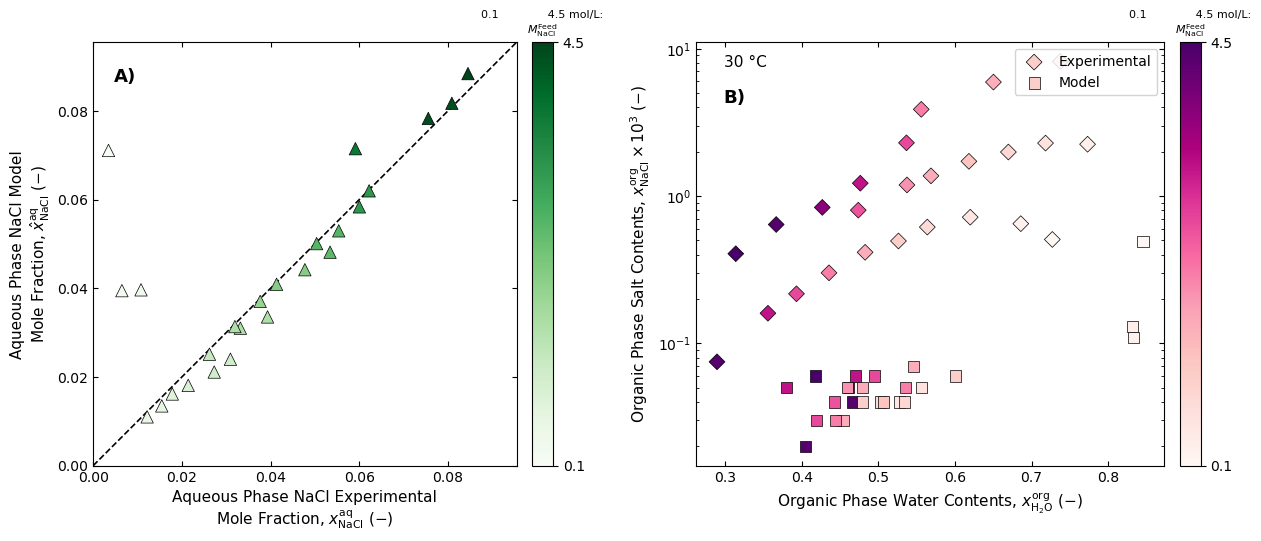

Done.


In [3]:
"""
plot_parity_style.py
====================
Two-panel publication figure for the NaCl-DIPA-H2O LIQUAC system:

  A) Aqueous-phase NaCl mole fraction: model vs experimental
     * green colormap, triangle markers, coloured by feed NaCl molality
  B) Organic-phase NaCl (x10^3) vs organic-phase water mole fraction
     * magenta/purple colormap, log y-axis
     * experimental = diamonds, model = squares

All data (experimental + model) are read from results_liquac.csv.
Feed molality for the colormap is computed from z_exp.xlsx.

Usage:
    python plot_parity_style.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path

# =============================================================================
# USER SETTINGS
# =============================================================================

SALT        = "NaCl"
SOLVENT     = "DIPA"
DATA_DIR    = ""        # parent folder containing NaCl-DIPA/ (leave "" for cwd)
TEMPERATURE = 30        # degrees C label shown inside panel B

SAVE_FIGURE   = True
OUTPUT_FORMAT = "png"   # "png", "pdf", or "svg"
FIGURE_NAME   = "parity_NaCl_DIPA"

# Colorbar limits (mol/L)
CBAR_MIN = 0.1
CBAR_MAX = 4.5

# Column names in results_liquac.csv
# Experimental
COL_EXP = dict(
    xR_Na  = "xR_exp_cation",   # aqueous-phase NaCl experimental
    xE_Na  = "xE_exp_cation",   # organic-phase  NaCl experimental
    xE_H2O = "xE_exp_water",    # organic-phase  H2O  experimental
)
# Model predictions
COL_MOD = dict(
    xR_Na  = "xR_cation",       # aqueous-phase NaCl model
    xE_Na  = "xE_cation",       # organic-phase  NaCl model
    xE_H2O = "xE_water",        # organic-phase  H2O  model
)

# =============================================================================


def feed_molality(z_df):
    """mol NaCl / kg H2O computed from feed mole-fraction file."""
    MW_H2O = 0.018015  # kg/mol
    return z_df["Na"].values / (z_df["H2O"].values * MW_H2O)


def load_all(data_dir):
    d = Path(data_dir) / f"{SALT}-{SOLVENT}"

    # Feed composition for colormap
    z = pd.read_excel(d / "z_exp.xlsx", header=0)
    z.columns = ["DIPA", "H2O", "Na", "Cl"]

    # Model + experimental results
    results = pd.read_csv(d / "results_liquac.csv")
    print(f"Loaded {len(results)} tie-lines from results_liquac.csv")

    return z, results, d


# ── Panel A -------------------------------------------------------------------

def panel_A(ax, xR_exp_Na, xR_mod_Na, m_feed):
    """Aqueous-phase NaCl parity plot (green colormap, triangle markers)."""
    norm = mcolors.Normalize(vmin=CBAR_MIN, vmax=CBAR_MAX)
    cmap = plt.get_cmap("Greens")

    lim_max = np.nanmax(np.concatenate([xR_exp_Na, xR_mod_Na])) * 1.08

    # Parity line
    ax.plot([0, lim_max], [0, lim_max], "k--", linewidth=1.2, zorder=1)

    # Scatter
    sc = ax.scatter(xR_exp_Na, xR_mod_Na,
                    c=m_feed, cmap=cmap, norm=norm,
                    marker="^", s=80,
                    edgecolors="black", linewidths=0.5, zorder=3)

    ax.set_xlim(0, lim_max)
    ax.set_ylim(0, lim_max)
    ax.set_aspect("equal", adjustable="box")

    ax.set_xlabel(
        "Aqueous Phase NaCl Experimental\n"
        "Mole Fraction, $x_{\\rm NaCl}^{\\rm aq}$ $(-) $", fontsize=11)
    ax.set_ylabel(
        "Aqueous Phase NaCl Model\n"
        "Mole Fraction, $\\hat{x}_{\\rm NaCl}^{\\rm aq}$ $(-) $", fontsize=11)

    ax.text(0.05, 0.94, "A)", transform=ax.transAxes,
            fontsize=13, fontweight="bold", va="top")
    ax.tick_params(direction="in", which="both", top=True, right=True)

    # Colorbar
    cbar = plt.colorbar(sc, ax=ax, pad=0.03, fraction=0.046)
    cbar.ax.set_title(
        f"{CBAR_MIN}              {CBAR_MAX} mol/L:\n"
        "$M_{\\rm NaCl}^{\\rm Feed}$", fontsize=8, pad=6)
    cbar.set_ticks([CBAR_MIN, CBAR_MAX])
    cbar.set_ticklabels([str(CBAR_MIN), str(CBAR_MAX)])


# ── Panel B -------------------------------------------------------------------

def panel_B(ax, xE_exp_Na, xE_exp_H2O, xE_mod_Na, xE_mod_H2O, m_feed):
    """Organic NaCl (x10^3) vs organic water, log y-axis, magenta colormap."""
    norm = mcolors.Normalize(vmin=CBAR_MIN, vmax=CBAR_MAX)
    cmap = plt.get_cmap("RdPu")

    # Experimental -- diamonds
    ax.scatter(xE_exp_H2O, xE_exp_Na * 1e3,
               c=m_feed, cmap=cmap, norm=norm,
               marker="D", s=65, edgecolors="black", linewidths=0.5,
               zorder=3, label="Experimental")

    # Model -- squares
    ax.scatter(xE_mod_H2O, xE_mod_Na * 1e3,
               c=m_feed, cmap=cmap, norm=norm,
               marker="s", s=65, edgecolors="black", linewidths=0.5,
               zorder=3, label="Model")

    ax.set_yscale("log")
    ax.set_xlabel(
        "Organic Phase Water Contents, "
        "$x_{\\rm H_2O}^{\\rm org}$ $(-) $", fontsize=11)
    ax.set_ylabel(
        "Organic Phase Salt Contents, "
        "$x_{\\rm NaCl}^{\\rm org}\\times10^3$ $(-) $", fontsize=11)

    ax.text(0.06, 0.97, f"{TEMPERATURE} \u00b0C",
            transform=ax.transAxes, fontsize=11, va="top")
    ax.text(0.06, 0.89, "B)",
            transform=ax.transAxes, fontsize=13, fontweight="bold", va="top")

    ax.legend(loc="upper right", fontsize=10, frameon=True, framealpha=0.85)
    ax.tick_params(direction="in", which="both", top=True, right=True)

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.03, fraction=0.046)
    cbar.ax.set_title(
        f"{CBAR_MIN}              {CBAR_MAX} mol/L:\n"
        "$M_{\\rm NaCl}^{\\rm Feed}$", fontsize=8, pad=6)
    cbar.set_ticks([CBAR_MIN, CBAR_MAX])
    cbar.set_ticklabels([str(CBAR_MIN), str(CBAR_MAX)])


# ── Main ----------------------------------------------------------------------

def main():
    print("=" * 65)
    print("NaCl-DIPA PARITY PLOT GENERATOR")
    print("=" * 65)

    z, results, data_dir = load_all(DATA_DIR)

    m_feed = feed_molality(z)
    print(f"Feed NaCl molality : {m_feed.min():.3f} - {m_feed.max():.3f} mol/kg")

    # Pull arrays from results CSV
    xR_exp_Na  = results[COL_EXP["xR_Na"]].values
    xE_exp_Na  = results[COL_EXP["xE_Na"]].values
    xE_exp_H2O = results[COL_EXP["xE_H2O"]].values

    xR_mod_Na  = results[COL_MOD["xR_Na"]].values
    xE_mod_Na  = results[COL_MOD["xE_Na"]].values
    xE_mod_H2O = results[COL_MOD["xE_H2O"]].values

    # Build figure
    fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
    fig.patch.set_facecolor("white")

    panel_A(axes[0], xR_exp_Na, xR_mod_Na, m_feed)
    panel_B(axes[1], xE_exp_Na, xE_exp_H2O, xE_mod_Na, xE_mod_H2O, m_feed)

    plt.tight_layout(w_pad=3)

    if SAVE_FIGURE:
        out = data_dir / f"{FIGURE_NAME}.{OUTPUT_FORMAT}"
        plt.savefig(out, dpi=300, bbox_inches="tight")
        print(f"\n[OK] Figure saved: {out}")

    plt.show()
    print("Done.")


if __name__ == "__main__":
    main()

NaCl-DIPA PARITY PLOT GENERATOR
Loaded 25 tie-lines from results_liquac.csv
Temperatures (K): [np.float64(288.15), np.float64(298.15), np.float64(303.15)]

Panel B: 10 points at 303.15 K (indices [8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

[OK] Figure saved: NaCl-DIPA/parity_NaCl_DIPA.png


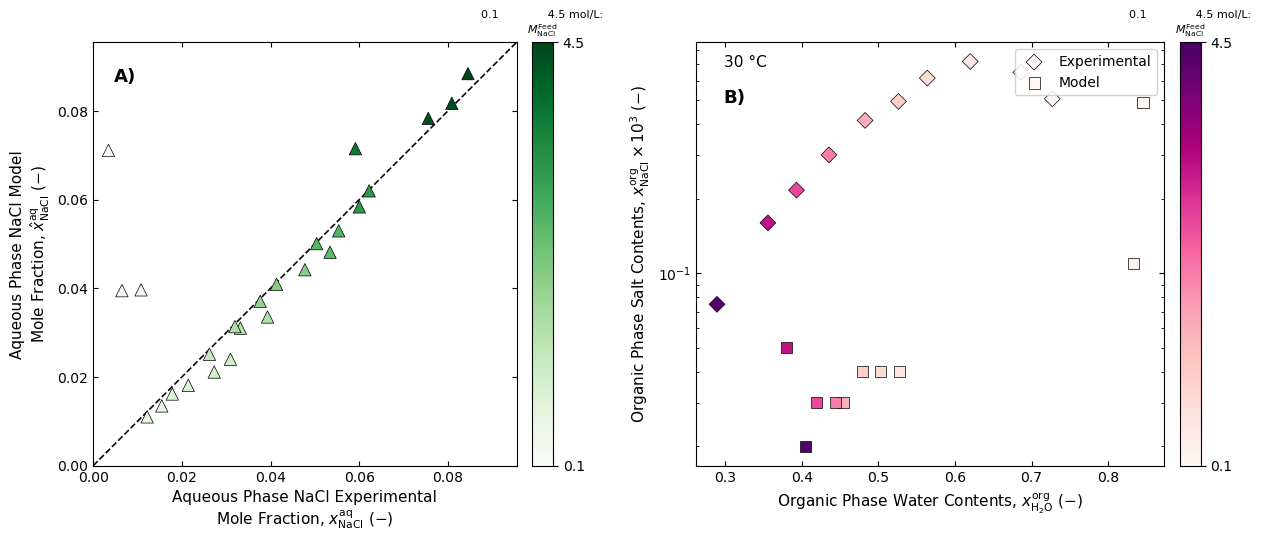

Done.


In [4]:
"""
plot_parity_style.py
====================
Two-panel publication figure for the NaCl-DIPA-H2O LIQUAC system:

  A) Aqueous-phase NaCl mole fraction: model vs experimental
     * ALL temperatures, green colormap, triangle markers
  B) Organic-phase NaCl (x10^3) vs organic-phase water mole fraction
     * 30 degC (303.15 K) DATA ONLY, magenta/purple colormap, log y-axis
     * experimental = diamonds, model = squares

Usage:
    python plot_parity_style.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path

# =============================================================================
# USER SETTINGS
# =============================================================================

SALT        = "NaCl"
SOLVENT     = "DIPA"
DATA_DIR    = ""        # parent folder containing NaCl-DIPA/ (leave "" for cwd)

# Temperature shown in Panel B (K) — only this temperature's data is plotted
T_PANEL_B   = 303.15    # K  (= 30 degC)
TEMPERATURE = 30        # degC label printed on panel B

SAVE_FIGURE   = True
OUTPUT_FORMAT = "png"
FIGURE_NAME   = "parity_NaCl_DIPA"

# Colorbar limits (mol/L)
CBAR_MIN = 0.1
CBAR_MAX = 4.5

# Column names in results_liquac.csv
COL_EXP = dict(
    xR_Na  = "xR_exp_cation",
    xE_Na  = "xE_exp_cation",
    xE_H2O = "xE_exp_water",
)
COL_MOD = dict(
    xR_Na  = "xR_cation",
    xE_Na  = "xE_cation",
    xE_H2O = "xE_water",
)

# =============================================================================


def feed_molality(z_df):
    MW_H2O = 0.018015  # kg/mol
    return z_df["Na"].values / (z_df["H2O"].values * MW_H2O)


def load_all(data_dir):
    d = Path(data_dir) / f"{SALT}-{SOLVENT}"

    z = pd.read_excel(d / "z_exp.xlsx", header=0)
    z.columns = ["DIPA", "H2O", "Na", "Cl"]

    T = pd.read_excel(d / "T_exp.xlsx", header=0)
    T.columns = ["T"]

    results = pd.read_csv(d / "results_liquac.csv")
    print(f"Loaded {len(results)} tie-lines from results_liquac.csv")
    print(f"Temperatures (K): {sorted(T['T'].unique())}")

    return z, T, results, d


# ── Panel A -------------------------------------------------------------------

def panel_A(ax, xR_exp_Na, xR_mod_Na, m_feed):
    """Aqueous-phase NaCl parity plot — all temperatures."""
    norm = mcolors.Normalize(vmin=CBAR_MIN, vmax=CBAR_MAX)
    cmap = plt.get_cmap("Greens")

    lim_max = np.nanmax(np.concatenate([xR_exp_Na, xR_mod_Na])) * 1.08

    ax.plot([0, lim_max], [0, lim_max], "k--", linewidth=1.2, zorder=1)

    sc = ax.scatter(xR_exp_Na, xR_mod_Na,
                    c=m_feed, cmap=cmap, norm=norm,
                    marker="^", s=80,
                    edgecolors="black", linewidths=0.5, zorder=3)

    ax.set_xlim(0, lim_max)
    ax.set_ylim(0, lim_max)
    ax.set_aspect("equal", adjustable="box")

    ax.set_xlabel(
        "Aqueous Phase NaCl Experimental\n"
        "Mole Fraction, $x_{\\rm NaCl}^{\\rm aq}$ $(-) $", fontsize=11)
    ax.set_ylabel(
        "Aqueous Phase NaCl Model\n"
        "Mole Fraction, $\\hat{x}_{\\rm NaCl}^{\\rm aq}$ $(-) $", fontsize=11)

    ax.text(0.05, 0.94, "A)", transform=ax.transAxes,
            fontsize=13, fontweight="bold", va="top")
    ax.tick_params(direction="in", which="both", top=True, right=True)

    cbar = plt.colorbar(sc, ax=ax, pad=0.03, fraction=0.046)
    cbar.ax.set_title(
        f"{CBAR_MIN}              {CBAR_MAX} mol/L:\n"
        "$M_{\\rm NaCl}^{\\rm Feed}$", fontsize=8, pad=6)
    cbar.set_ticks([CBAR_MIN, CBAR_MAX])
    cbar.set_ticklabels([str(CBAR_MIN), str(CBAR_MAX)])


# ── Panel B -------------------------------------------------------------------

def panel_B(ax, xE_exp_Na, xE_exp_H2O, xE_mod_Na, xE_mod_H2O, m_feed):
    """Organic NaCl (x10^3) vs organic water — 30 degC only, log y-axis."""
    norm = mcolors.Normalize(vmin=CBAR_MIN, vmax=CBAR_MAX)
    cmap = plt.get_cmap("RdPu")

    ax.scatter(xE_exp_H2O, xE_exp_Na * 1e3,
               c=m_feed, cmap=cmap, norm=norm,
               marker="D", s=65, edgecolors="black", linewidths=0.5,
               zorder=3, label="Experimental")

    ax.scatter(xE_mod_H2O, xE_mod_Na * 1e3,
               c=m_feed, cmap=cmap, norm=norm,
               marker="s", s=65, edgecolors="black", linewidths=0.5,
               zorder=3, label="Model")

    ax.set_yscale("log")
    ax.set_xlabel(
        "Organic Phase Water Contents, "
        "$x_{\\rm H_2O}^{\\rm org}$ $(-) $", fontsize=11)
    ax.set_ylabel(
        "Organic Phase Salt Contents, "
        "$x_{\\rm NaCl}^{\\rm org}\\times10^3$ $(-) $", fontsize=11)

    ax.text(0.06, 0.97, f"{TEMPERATURE} \u00b0C",
            transform=ax.transAxes, fontsize=11, va="top")
    ax.text(0.06, 0.89, "B)",
            transform=ax.transAxes, fontsize=13, fontweight="bold", va="top")

    ax.legend(loc="upper right", fontsize=10, frameon=True, framealpha=0.85)
    ax.tick_params(direction="in", which="both", top=True, right=True)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.03, fraction=0.046)
    cbar.ax.set_title(
        f"{CBAR_MIN}              {CBAR_MAX} mol/L:\n"
        "$M_{\\rm NaCl}^{\\rm Feed}$", fontsize=8, pad=6)
    cbar.set_ticks([CBAR_MIN, CBAR_MAX])
    cbar.set_ticklabels([str(CBAR_MIN), str(CBAR_MAX)])


# ── Main ----------------------------------------------------------------------

def main():
    print("=" * 65)
    print("NaCl-DIPA PARITY PLOT GENERATOR")
    print("=" * 65)

    z, T, results, data_dir = load_all(DATA_DIR)

    m_feed = feed_molality(z)

    # ── Panel A: all temperatures ─────────────────────────────────────────────
    xR_exp_Na = results[COL_EXP["xR_Na"]].values
    xR_mod_Na = results[COL_MOD["xR_Na"]].values

    # ── Panel B: 30 degC (T_PANEL_B) only ────────────────────────────────────
    mask_30 = (T["T"].values == T_PANEL_B)
    print(f"\nPanel B: {mask_30.sum()} points at {T_PANEL_B} K "
          f"(indices {np.where(mask_30)[0].tolist()})")

    xE_exp_Na  = results[COL_EXP["xE_Na"]].values[mask_30]
    xE_exp_H2O = results[COL_EXP["xE_H2O"]].values[mask_30]
    xE_mod_Na  = results[COL_MOD["xE_Na"]].values[mask_30]
    xE_mod_H2O = results[COL_MOD["xE_H2O"]].values[mask_30]
    m_feed_30  = m_feed[mask_30]

    # ── Build figure ──────────────────────────────────────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
    fig.patch.set_facecolor("white")

    panel_A(axes[0], xR_exp_Na, xR_mod_Na, m_feed)
    panel_B(axes[1], xE_exp_Na, xE_exp_H2O, xE_mod_Na, xE_mod_H2O, m_feed_30)

    plt.tight_layout(w_pad=3)

    if SAVE_FIGURE:
        out = data_dir / f"{FIGURE_NAME}.{OUTPUT_FORMAT}"
        plt.savefig(out, dpi=300, bbox_inches="tight")
        print(f"\n[OK] Figure saved: {out}")

    plt.show()
    print("Done.")


if __name__ == "__main__":
    main()